# What do the pdf updates look like?

Exploring how the input distribution changes under Fisher information updates.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib

In [137]:
from discriminationAnalysis import Fisher_smooth_fits
from basicModel import EstimateAngle

from adapt_fit_loop import moving_average

## pdf update for the concentrated case

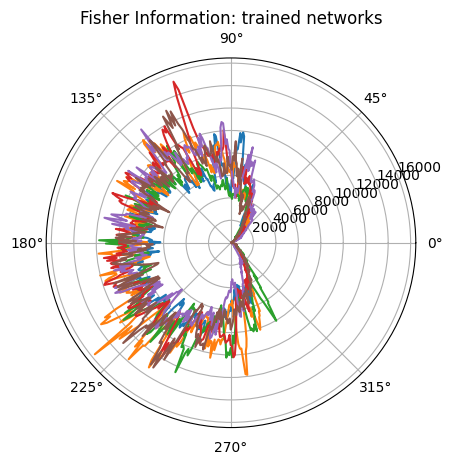

In [3]:
import glob

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.title('Fisher Information: trained networks')

ex4_conc_dir = 'trainedParameters/Exp4_conc/'

FIcurves_conc = []

for rep in range(6):
    trained_ckpt =  glob.glob(ex4_conc_dir + f'rep{rep}/epoch*')[0]
    
    model = EstimateAngle.load_from_checkpoint(trained_ckpt)

    fi = Fisher_smooth_fits(model, 0., np.pi, N_cov=500, Samp_cov=500)
    FIcurves_conc.append(fi)
    
    plt.plot(np.linspace(0, 2*np.pi, 500), fi)

In [4]:
np.array(FIcurves_conc).min(1)

array([14.69482853,  9.7832375 ,  0.17993534, 17.95820599, 25.27543399,
       18.58125288])

In [ ]:
fisher_curves = np.array(FIcurves_conc)

smoothed_mean_fisher = moving_average(np.mean(fisher_curves, axis=0))

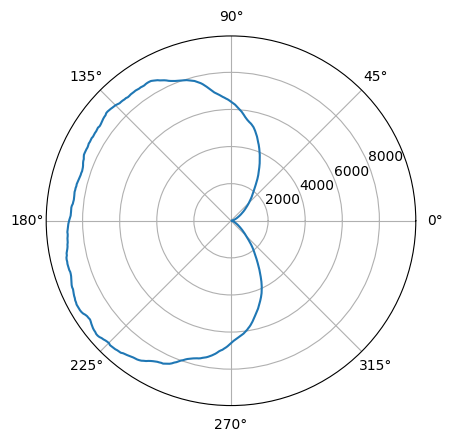

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot(np.linspace(0, 2*np.pi, 500), smoothed_mean_fisher)

In [ ]:
unif = np.ones(500)

p1 = unif / smoothed_mean_fisher**0.5
p1 = p1 / p1.sum()

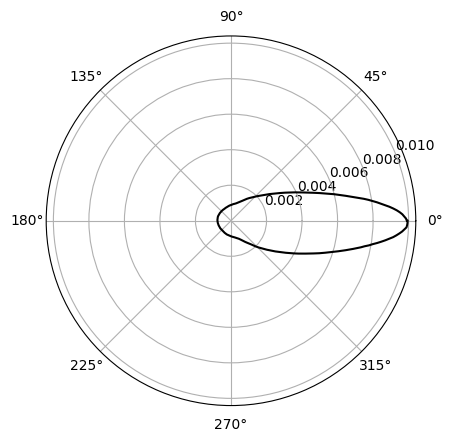

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 
plt.plot(np.linspace(0, 2*np.pi, 500), p1, 'k')

Experiment 4 concentrated was trained with the data concentrated around pi /2.

Note for these plots, I am doubling the angular scale for ease of visualization of the periodic signal. Thus, angles close to zero are, in fact, orthogonal to the pi/2 angles.

What is the idea of the iteration?
1. this network has its Fisher information concentrated at pi/2.
2. fine-tuning on the reverse, concentrated around 0, should, thus, remove this sensitivity bias.

Finetuning what? Should we finetune this network (the already trained one), or the previous network that we trained in order to get this response to the current stimulus distribution?




#### Note for the record:
These are seperately trained versions of the network that we are averaging over to determine the Fisher information.

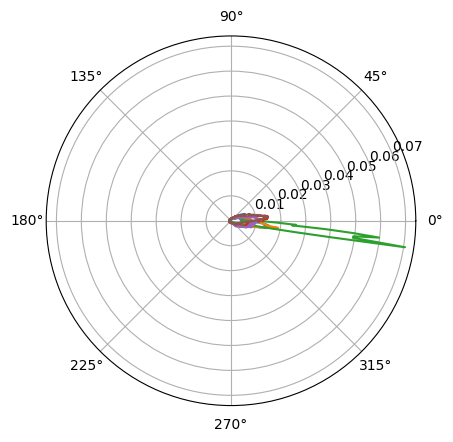

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
 
for fi in FIcurves_conc:
    c = unif / fi**0.5
    plt.plot(np.linspace(0, 2*np.pi, 500), c / c.sum())


The individual runs can produce very noisy results.

### Ideas as to why the convergence fails:

1. There are modes that are amplified, rather than damped in the fitting process.
   - essentially this is the case if the distribution above is more extreme than the distribution that the network was trained on.

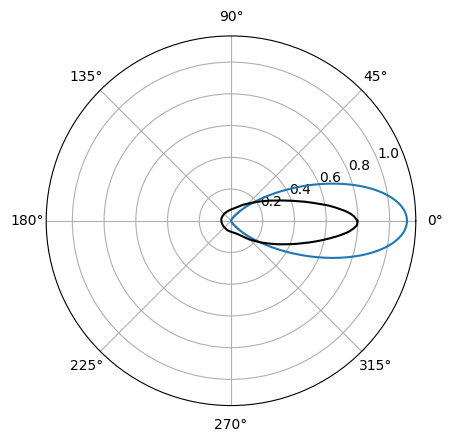

In [ ]:
from scipy.stats import vonmises
from scipy.integrate import trapezoid

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

x = np.linspace(0, 2*np.pi, 500)


p1 = unif / smoothed_mean_fisher**0.5
p1 = p1 / trapezoid(p1, x)

plt.plot(x, vonmises(8., 0).pdf( x))
 
plt.plot(x, p1, 'k')

I have to be careful here about how these are normalized, and to what x domain. However, the fact that the values near zero are 'rounded out' is hopeful.

In [ ]:
from adaptableModel import AngleDistribution

In [ ]:
# this is the former default
a= AngleDistribution(p1, [-np.pi, np.pi])

In [ ]:
update_samples = a.sample(10000)
prior_samples =  vonmises(8., 0).rvs( 10000)

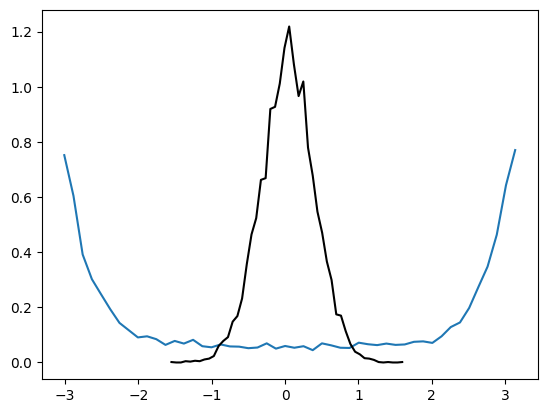

In [ ]:
n_update, b_update = np.histogram(update_samples, bins=50, density=True)
plt.plot(b_update[1:], n_update)

n_prior, b_prior = np.histogram(prior_samples, bins=50, density=True)
plt.plot(b_prior[1:], n_prior, 'k')

Ok, this is reasonable good to show the distribution is, in fact getting more uniform, at least for this one step.

In [ ]:
test = AngleDistribution( vonmises(8., 0).pdf( x), [-np.pi, np.pi])

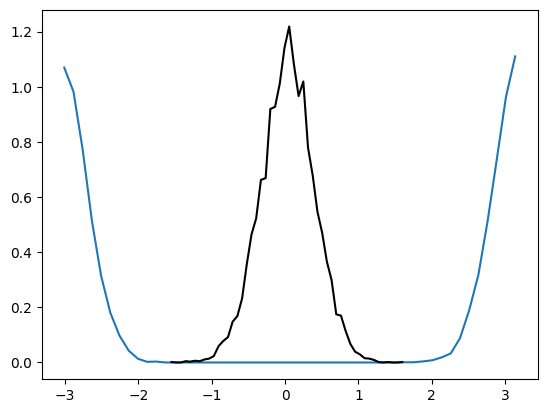

In [ ]:
test_num, test_bins = np.histogram(test.sample(10000), bins=50, density=True)

plt.plot(test_bins[1:], test_num)
plt.plot(b_prior[1:], n_prior, 'k')

#### These are possible issues:
- AngleDistribution appears to rotate the angles by 180 degrees
- AngleDistribution also uses angles betwee -pi and pi rather that 0 to pi (or some other half length parameterization), which is inconsistent with the generation.

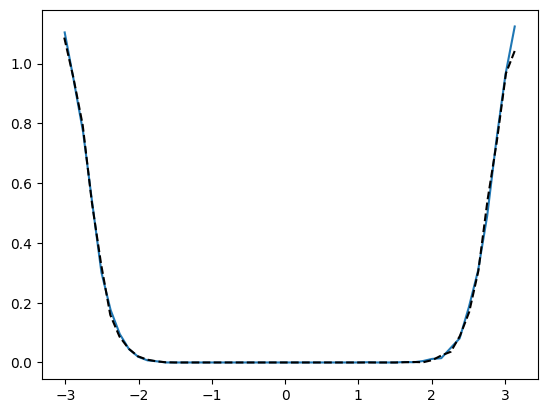

In [ ]:
test_num, test_bins = np.histogram(test.sample(10000), bins=50, density=True)
rotated_num, rotated_bins = np.histogram( vonmises(8.,np.pi).rvs(10000), bins=50, density=True)

plt.plot(test_bins[1:], test_num)
plt.plot(rotated_bins[1:], rotated_num, '--k')

The density itself seems reasonably unchanged.

## What do the iterates look like?

Text(0.5, 1.0, 'Untrained Network Trajectory')

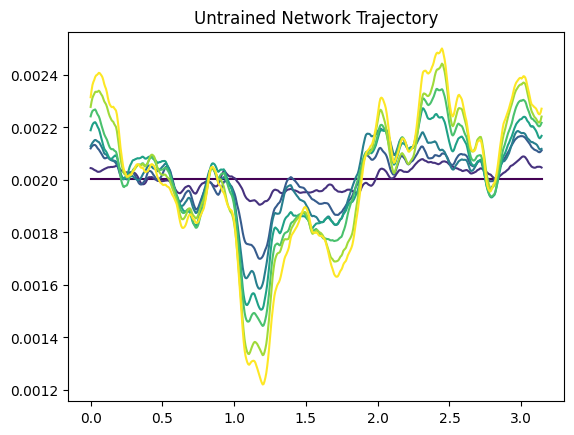

In [70]:
from adaptableModel import AngleDistribution

data =pd.read_pickle('trainedParameters/Exp6/untrained/iterate_data.pickle')

colors = plt.cm.viridis(np.linspace(0,1,8))
for row in data[ data.measurement=='probability'].to_dict(orient="records"):
    itr = row['iteration']
    if itr > 0:
        itr = itr-1
    
    dist = AngleDistribution(row['data'], [0, np.pi])
    plt.plot(np.linspace(0, np.pi, dist.npoints-1), dist.bin_probs, c=colors[itr])

plt.title('Untrained Network Trajectory')


Text(0.5, 1.0, 'Uniform Network Trajectory')

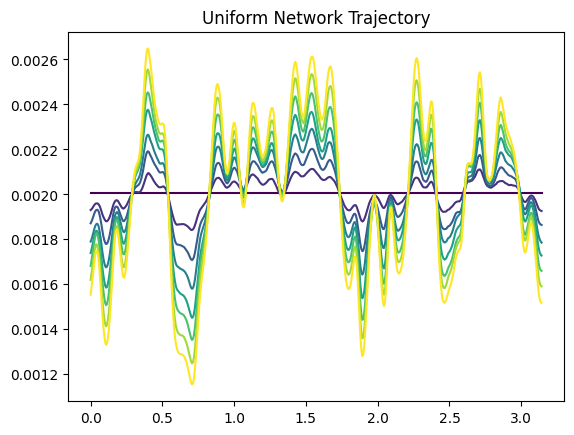

In [72]:
data =pd.read_pickle('trainedParameters/Exp6/uniform/iterate_data.pickle')

colors = plt.cm.viridis(np.linspace(0,1,8))
for row in data[ data.measurement=='probability'].to_dict(orient="records"):
    itr = row['iteration']
    if itr > 0:
        itr = itr-1
    
    dist = AngleDistribution(row['data'], [0, np.pi])
    plt.plot(np.linspace(0, np.pi, dist.npoints-1), dist.bin_probs, c=colors[itr])

plt.title('Uniform Network Trajectory')

Text(0.5, 1.0, 'Concentrated Network Trajectory')

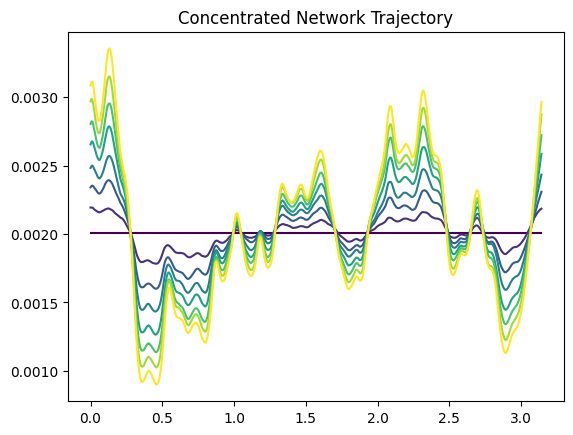

In [98]:
data =pd.read_pickle('trainedParameters/Exp6/concentrated/iterate_data.pickle')

colors = plt.cm.viridis(np.linspace(0,1,8))
for row in data[ data.measurement=='probability'].to_dict(orient="records"):
    itr = row['iteration']
    if itr > 0:
        itr = itr-1
    
    dist = AngleDistribution(row['data'], [0, np.pi])
    plt.plot(np.linspace(0, np.pi, dist.npoints-1), dist.bin_probs, c=colors[itr])

plt.title('Concentrated Network Trajectory')

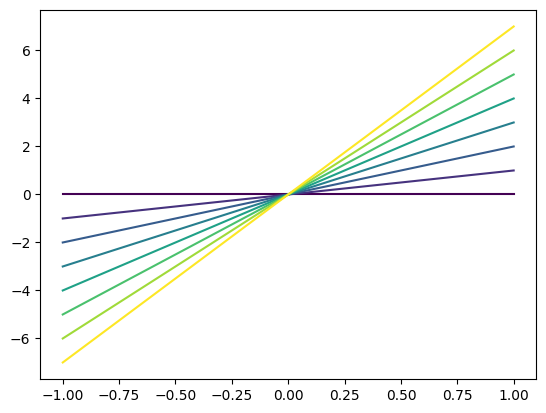

In [92]:
xs =np.linspace(-1, 1, 201)
for i in range(8):
    plt.plot(xs, i* xs, c=colors[i])

### The trend here is clear.

It seems that the small deviations in the probability distributions are being successively amplified through the process of finetuning and fitting the Fisher information.

This is a little surprising:  
The concentrated network appears to have its biases pretty well removed by the initial fine-tuning, but the newly introduced small biases aren't trained away? How does that make sense?

In [147]:
concentrated_data =pd.read_pickle('trainedParameters/Exp6/concentrated/iterate_data.pickle')


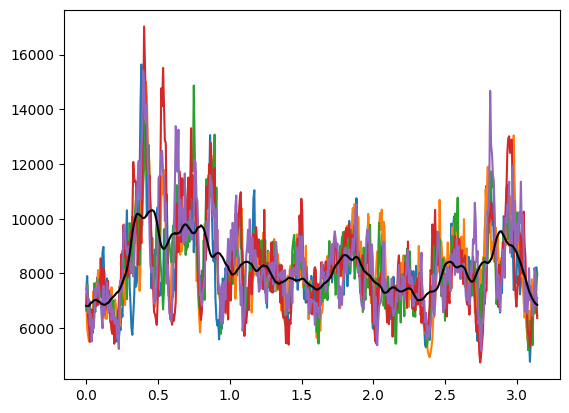

In [148]:
raw = concentrated_data[(concentrated_data.measurement == 'FI') & 
                          (concentrated_data.iteration == 0)]['data']

xs = np.linspace(0, np.pi,500)
for row in raw:
    plt.plot(xs, row)
    
smoothed_mean_fisher = moving_average(np.mean(raw, axis=0))
plt.plot(xs, smoothed_mean_fisher, 'k')


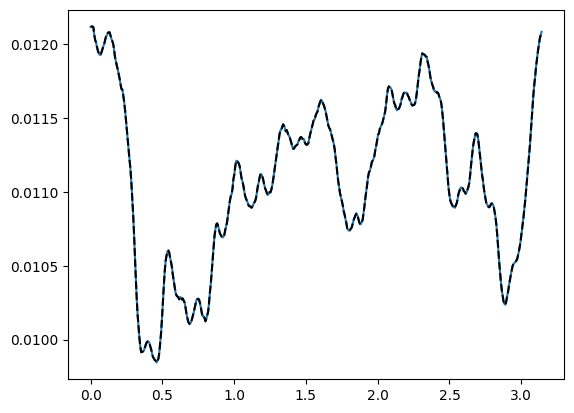

In [149]:
recorded = concentrated_data[(concentrated_data.iteration == 2) &
                             (concentrated_data.measurement == 'probability')]['data'].iloc[0]

plt.plot(xs, 1./smoothed_mean_fisher**0.5)
plt.plot(xs, recorded, '--k')

Ok, good double check: the probability distribution is calculated as expected.


### interim summary:

This is a seemingly paradoxical result:
1. In this case, $p(s_1) - p(s_2) > 0$ means that $p'(s_1) - p'(s_2) >  p(s_1) - p(s_2)$. Thus, $p(s_1) / \sqrt{I(s_1)} -  p(s_2) / \sqrt{I(s_2)} >  p(s_1) - p(s_2)$...



## Is there actually a negative correlation between the probability density that the networks were trained on and the Fisher information in the resulting networks?

What if we plot the pdf that we fine-tuned on vs the Fisher information measurements?

In [149]:
concentrated_data = pd.read_pickle('trainedParameters/Exp6/concentrated/iterate_data.pickle')
uniform_data = pd.read_pickle('trainedParameters/Exp6/uniform/iterate_data.pickle')
untrained_data = pd.read_pickle('trainedParameters/Exp6/untrained/iterate_data.pickle')

# fix the indexing issues in the experiment script
inds =concentrated_data[ concentrated_data['measurement'] == 'probability'].index
concentrated_data.loc[inds, 'iteration'] = range(8)
uniform_data.loc[inds, 'iteration'] = range(8)
untrained_data.loc[inds, 'iteration'] = range(8)

Text(0, 0.5, 'Fisher Info')

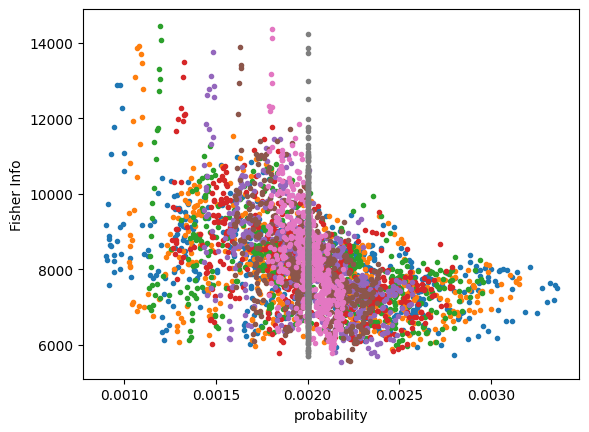

In [231]:
pt = concentrated_data.pivot_table(index='iteration', columns='measurement',
                                   values='data', aggfunc='mean')

for row in pt.to_dict(orient="records")[::-1]:
    dist = AngleDistribution(row['probability'], [0, np.pi])
    plt.plot(dist.bin_probs, row['FI'][1:], '.')
plt.xlabel('probability')
plt.ylabel('Fisher Info')
    

Text(0, 0.5, 'Fisher Info')

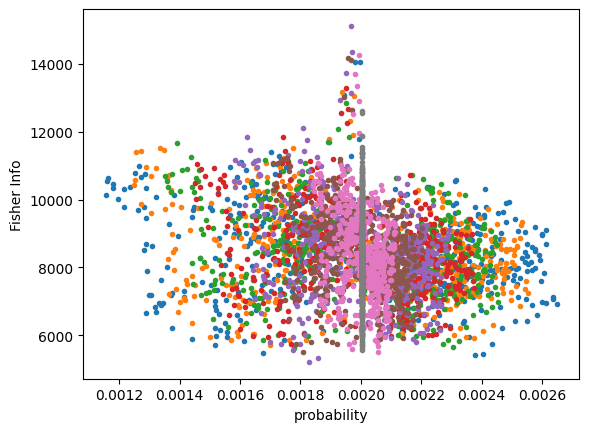

In [234]:
pt = uniform_data.pivot_table(index='iteration', columns='measurement',
                                   values='data', aggfunc='mean')

for row in pt.to_dict(orient="records")[::-1]:
    dist = AngleDistribution(row['probability'], [0, np.pi])
    plt.plot(dist.bin_probs, row['FI'][1:], '.')
plt.xlabel('probability')
plt.ylabel('Fisher Info')
    

Text(0, 0.5, 'Fisher Info')

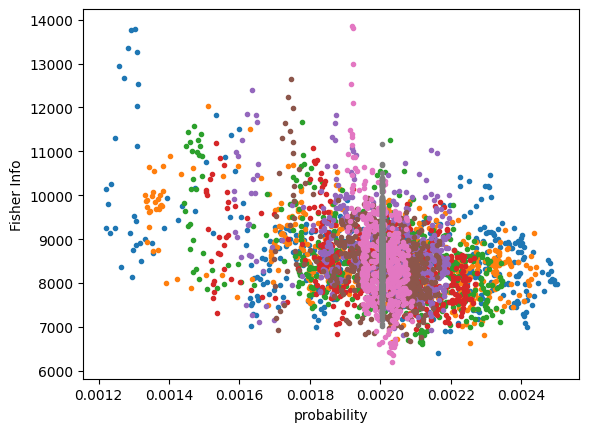

In [235]:
pt = untrained_data.pivot_table(index='iteration', columns='measurement',
                                   values='data', aggfunc='mean')

for row in pt.to_dict(orient="records")[::-1]:
    dist = AngleDistribution(row['probability'], [0, np.pi])
    plt.plot(dist.bin_probs, row['FI'][1:], '.')
plt.xlabel('probability')
plt.ylabel('Fisher Info')

Note that I'm plotting these in reverse order (so grey is the first iteration, then pink, etc).  

As the iterations continue (and the probabilities diffuse outward), we see the the gradual emergence of an inverse correlation between probability in the training set and the Fisher information of the learned mapping.

This is the exact opposite of the case previously!

### Did the previous case actually show what I thought?

0
1


KeyboardInterrupt: 

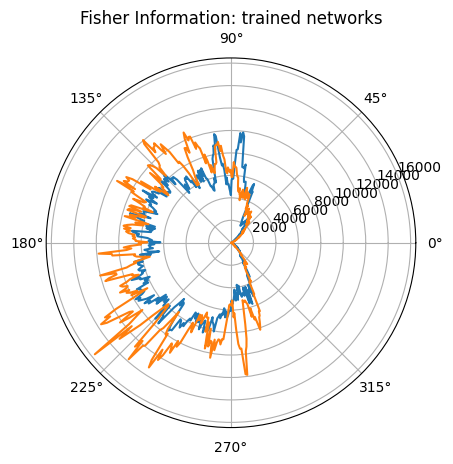

In [3]:
import glob

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.title('Fisher Information: trained networks')

ex4_conc_dir = 'trainedParameters/Exp4_conc/'

FIcurves_conc = []

for rep in range(6):
    trained_ckpt =  glob.glob(ex4_conc_dir + f'rep{rep}/epoch*')[0]
    
    model = EstimateAngle.load_from_checkpoint(trained_ckpt)

    fi = Fisher_smooth_fits(model, 0., np.pi, N_cov=500, Samp_cov=500)
    FIcurves_conc.append(fi)

    print(rep)
    plt.plot(np.linspace(0, 2*np.pi, 500), fi)

In [6]:
from scipy.stats import vonmises

In [20]:
dist_exp4 = vonmises(8., np.pi/2)
samples= dist_exp4.rvs(10000)

(array([   6.,    3.,   33.,   71.,  184.,  336.,  685., 1171., 1462.,
        1608., 1539., 1239.,  805.,  480.,  224.,   87.,   35.,   20.,
           9.,    3.]),
 array([0.13851379, 0.28685553, 0.43519727, 0.58353902, 0.73188076,
        0.8802225 , 1.02856424, 1.17690599, 1.32524773, 1.47358947,
        1.62193121, 1.77027295, 1.9186147 , 2.06695644, 2.21529818,
        2.36363992, 2.51198167, 2.66032341, 2.80866515, 2.95700689,
        3.10534863]),
 <BarContainer object of 20 artists>)

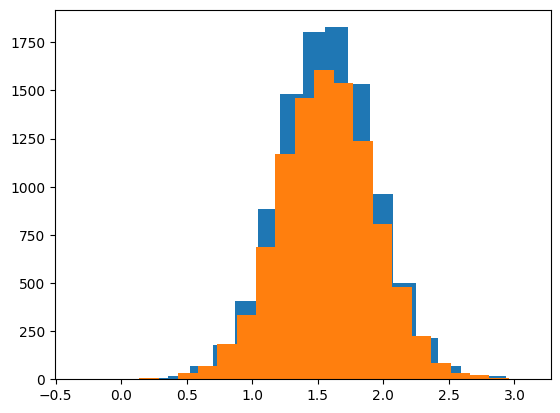

In [35]:
plt.hist(samples, bins=20)
plt.hist(samples %np.pi, bins=20)

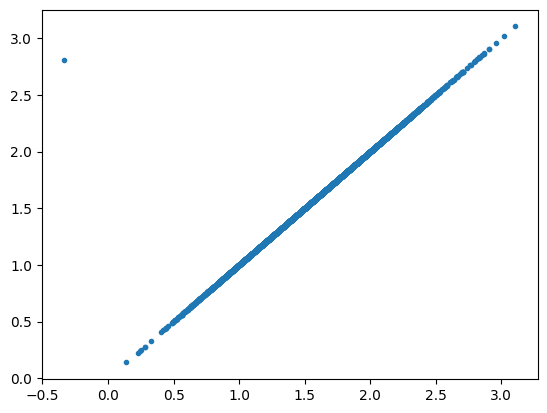

In [33]:
plt.plot(samples, samples % np.pi, '.')

Ok, this is nice: our distributions are very concentrated, so the way that we projected the data down to (0, pi) doesn't really matter.

In [44]:
samples= dist_exp4.rvs(50000) % np.pi
count, bins = np.histogram(samples, bins=np.linspace(0, np.pi, 501), density=True)

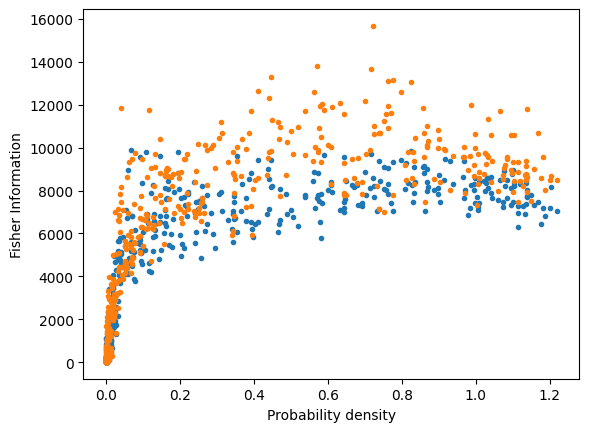

In [48]:
for y in FIcurves_conc:
    plt.plot(count, y, '.')

plt.xlabel('Probability density')
plt.ylabel('Fisher Information');

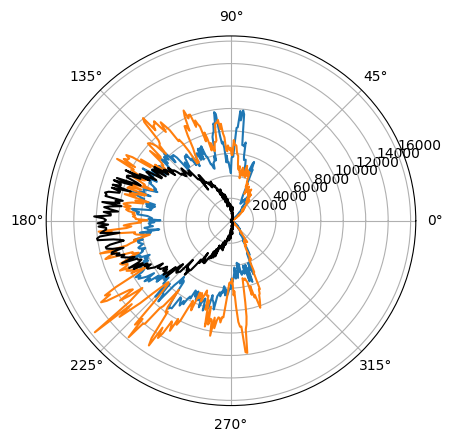

In [54]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for y in FIcurves_conc:
    plt.plot(np.linspace(0, 2*np.pi, 500), y)

plt.plot(np.linspace(0, 2*np.pi, 500), 10000*count,'k')

Yes, indeed. Here we see a very different dependence between the probability density of the training distribution and the Fisher information in the learned network.

High density -> high Fisher information, and vice versa.

It's good to have triple checked this.

### Notes:

Thinking more about it, it is very strange to get such clean behavior. This is an average of multiple retrained samples, but it looks like there is basically no noise?

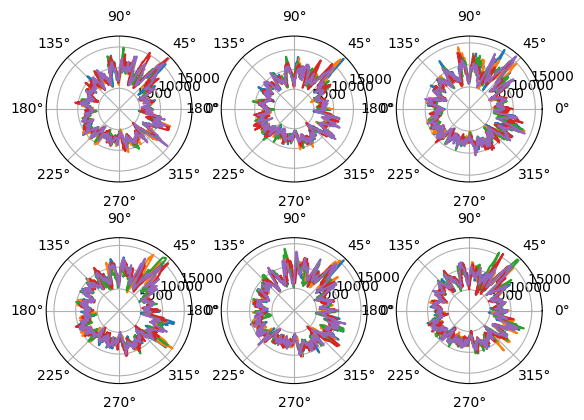

In [78]:
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'})

for ind in range(6):
    for fi in concentrated_data[(concentrated_data.measurement == 'FI')
                              & (concentrated_data.iteration == ind)]['data']:
        plt.subplot(2,3,ind+1)
        plt.plot(np.linspace(0, 2*np.pi, 500), fi)

No, but seriously, how are these so damn similar???

In [84]:
ckpts = glob.glob('trainedParameters/Exp6/concentrated/iter0/*')

In [87]:
from adaptableModel import AdaptableEstimator, AngleDistribution

In [97]:
U = AngleDistribution(np.ones(500), [0., np.pi])
for ckpt in ckpts:
    model = AdaptableEstimator.load_from_checkpoint(ckpt, angle_dist=U)
    print( model.hparams.seed )

967369843898950914
15346541979810798859
12711906263299886879
14665669494729647154
16652516071571257433


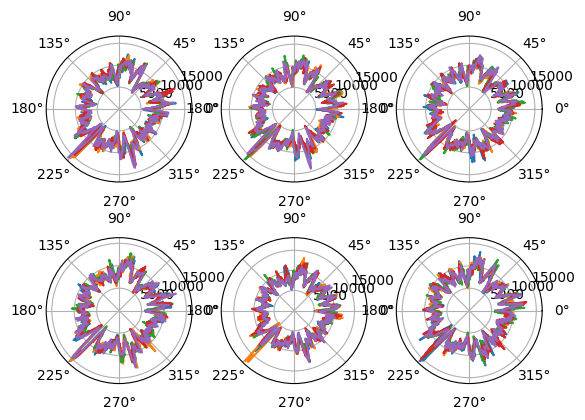

In [98]:
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'})

for ind in range(6):
    for fi in uniform_data[(uniform_data.measurement == 'FI')
                              & (uniform_data.iteration == ind)]['data']:
        plt.subplot(2,3,ind+1)
        plt.plot(np.linspace(0, 2*np.pi, 500), fi)

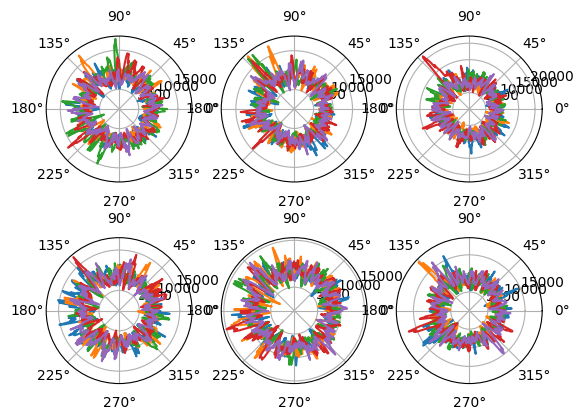

In [99]:
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'})

for ind in range(6):
    for fi in untrained_data[(untrained_data.measurement == 'FI')
                              & (untrained_data.iteration == ind)]['data']:
        plt.subplot(2,3,ind+1)
        plt.plot(np.linspace(0, 2*np.pi, 500), fi)

### Is it possibly overfitting?

The models that I'm using to assess the Fisher information aren't necessarily the best chekpoint, since I don't reload these from the file...

Indeed, running a quick check shows that final model parameters are _not_ the optimal ones.

I can test this by comparing the recorded Fisher information to the fits to Fisher information.

In [119]:
concentrated_rerun = []

flat_dist = AngleDistribution(np.ones(500), [0., np.pi])

for iter in range(8):
    files = glob.glob(f'trainedParameters/Exp6/concentrated/iter{iter}/*')

    for checkpoint in files:
        model = AdaptableEstimator.load_from_checkpoint(checkpoint,
                                                        angle_dist=flat_dist,
                                                        max_epochs=0
                                                        )
        fi = Fisher_smooth_fits(model, 0., np.pi, N_mean=10000, N_cov=500, Samp_cov=500)
        
        row = {'iteration': iter, 'data': fi}
        concentrated_rerun.append(row)
    print(iter)


0
1
2
3
4
5
6
7


In [125]:
concentrated_rerun = pd.DataFrame(concentrated_rerun)

In [127]:
concentrated_rerun.groupby('iteration').mean()

,data
iteration,
0,"[7621.458407643084, 7004.0889070300955, 6895.1..."
1,"[8126.678988741916, 8286.100369626003, 7994.64..."
2,"[7979.954776736768, 7580.665071036531, 7865.98..."
3,"[8077.784758112767, 7796.0586707988205, 8172.8..."
4,"[8362.651840080049, 8816.162014109344, 8063.81..."
5,"[8089.661711997667, 7962.0554153758085, 7504.7..."
6,"[8612.287292079103, 8410.9201702268, 8117.0090..."
7,"[8226.916994561674, 8726.015627317034, 7589.94..."


Text(0.5, 1.0, 'Fisher information - online record')

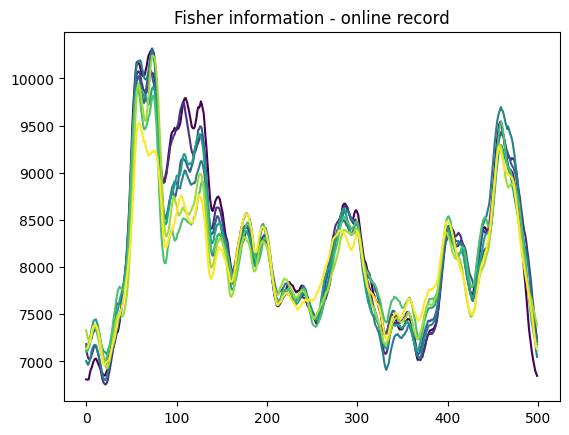

In [153]:
colors = plt.cm.viridis(np.linspace(0,1,8))
i =0

for row in concentrated_data[ concentrated_data.measurement == 'FI'
                            ].groupby('iteration').agg({'data': 'mean'}).sort_values('iteration')['data']:
    plt.plot(moving_average(row), c=colors[i])
    i += 1

plt.title('Fisher information - online record')

Text(0.5, 1.0, 'Fisher Information - posthoc evaluation')

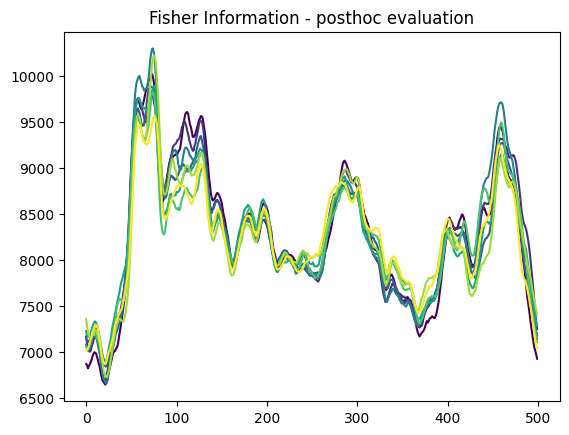

In [154]:
colors = plt.cm.viridis(np.linspace(0,1,8))
i =0

for row in concentrated_rerun.groupby('iteration').mean().sort_values('iteration')['data']:
    plt.plot(moving_average(row), c=colors[i])
    i += 1

plt.title('Fisher Information - posthoc evaluation')

1. There is some difference between the two sets of curves.

2. The differences across iterations don't look strong enough to produce the trend that we've observed in the previous plots.

Text(0.5, 1.0, 'Probability distribution')

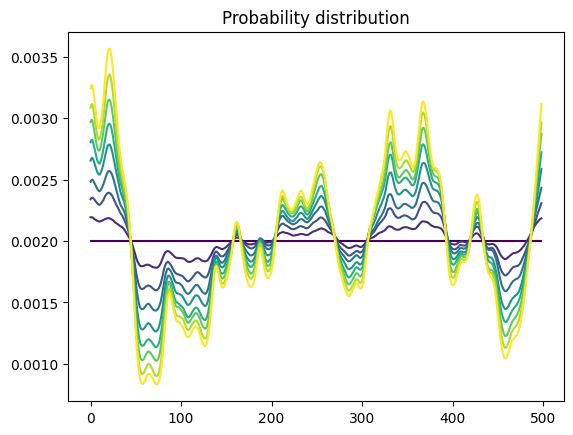

In [160]:
colors = plt.cm.viridis(np.linspace(0,1,9))

dist = AngleDistribution( np.ones(500), [0., np.pi])
plt.plot(dist.bin_probs, c=colors[0])

i = 1
for row in concentrated_data[ concentrated_data.measurement == 'FI'
                            ].groupby('iteration').agg({'data': 'mean'}).sort_values('iteration')['data']:

    new_values = dist.values / moving_average(row)**0.5
    dist = AngleDistribution(new_values, [0., np.pi])
    plt.plot(dist.bin_probs, c=colors[i])
    i += 1

plt.title('Probability distribution')

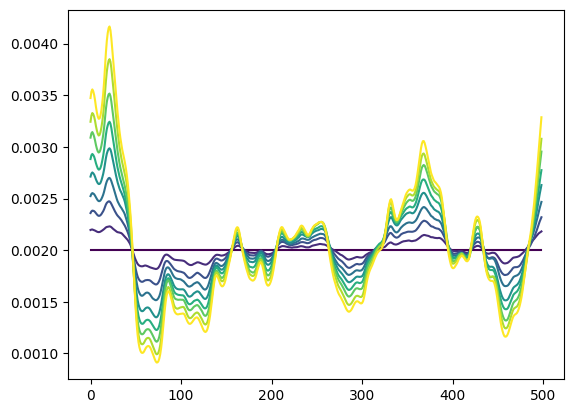

In [161]:
colors = plt.cm.viridis(np.linspace(0,1,9))

dist = AngleDistribution( np.ones(500), [0., np.pi])
plt.plot(dist.bin_probs, c=colors[0])

i = 1
for row in concentrated_rerun.groupby('iteration').mean().sort_values('iteration')['data']:
    new_values = dist.values / moving_average(row)**0.5
    dist = AngleDistribution(new_values, [0., np.pi])
    plt.plot(dist.bin_probs, c=colors[i])
    i += 1

### Interesting result

Ok, so it looks like the thing that causes this divergence is actually the fact that the Fisher information deviates from uniform in the _same characteristic way_ every time we refit the neural networks.

That is to say it's because the Fisher information curves all have the same large scale shape.

This means that we divide by the same thing every time, which in turn causes the amplification of deviations.

That also explains the very deterministic seeming nature of the deviations: it really is repeated division by the same curve.

#### The question is why its the same?
Why do the networks all share this structure??
* Is it the shared initialization?
* Is is a randomization failure?
* Is it an architecture failure?
* Is it a Fisher information fitting failure?

### Seed sharing

In [164]:
for ckpt in glob.glob('trainedParameters/Exp6/concentrated/iter0/*'):
    dist = AngleDistribution(np.ones(500), [0, np.pi])
    model = AdaptableEstimator.load_from_checkpoint( ckpt, angle_dist=dist)
    print(model.hparams.seed)

967369843898950914
15346541979810798859
12711906263299886879
14665669494729647154
16652516071571257433


In [165]:
for ckpt in glob.glob('trainedParameters/Exp6/concentrated/iter1/*'):
    dist = AngleDistribution(np.ones(500), [0, np.pi])
    model = AdaptableEstimator.load_from_checkpoint( ckpt, angle_dist=dist)
    print(model.hparams.seed)

10666304192740685704
12834590379526135592
10890395108299221895
11197852224913400512
13072276661895679149


The seeds that we recorded are not the same. Is it possible that the seed is not being set?

In [169]:
import torch
model1 = AdaptableEstimator.load_from_checkpoint(ckpt, angle_dist=dist, seed=torch.random.seed())
model2 = AdaptableEstimator.load_from_checkpoint(ckpt, angle_dist=dist, seed=torch.random.seed())

In [171]:
print(model1.hparams.seed, model2.hparams.seed)

13813948499615692093 7102135249791225486


In [172]:
model1.setup()

In [173]:
model2.setup()

In [181]:
model1.trainingData.angles

tensor([1.3316, 0.9727, 2.6663,  ..., 0.2046, 1.8856, 2.8803])

In [178]:
model2.trainingData.angles

tensor([1.5960, 1.6338, 2.3326,  ..., 0.0220, 2.0367, 2.5341])

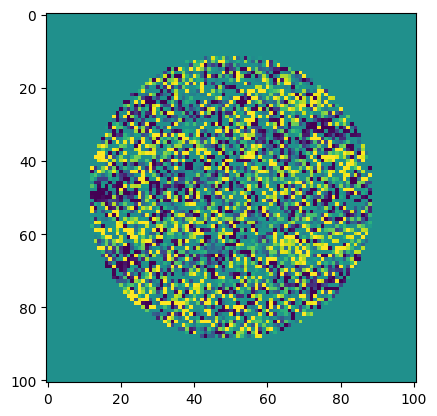

In [183]:
plt.imshow(model1.trainingData.images[0] - model2.trainingData.images[0])

Certainly the data generated within the two models looks different.

Also, the initialization code seems to run upon loading the models.

#### I'm pretty confident that the seeds are different between the models.

### Single iterates

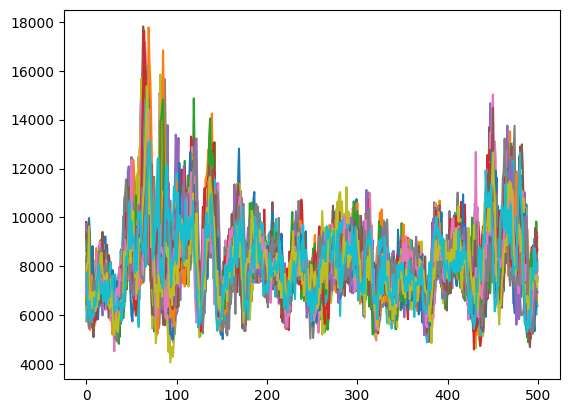

In [193]:
for fi in concentrated_data[(concentrated_data['measurement'] == 'FI')]['data']:
    plt.plot(fi)

It definitely looks more correlated than I would expect

Text(0.5, 1.0, 'Do all replicates in each iteration have the same structure?')

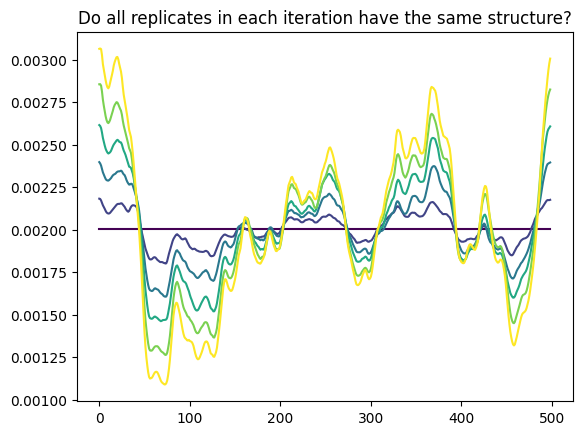

In [210]:
colors = plt.cm.viridis(np.linspace(0,1,6))

dist = AngleDistribution( np.ones(500), [0., np.pi])
plt.plot(dist.bin_probs, c=colors[0])

i = 1
for row in concentrated_data[(concentrated_data.measurement == 'FI') &
                             (concentrated_data.iteration == 0)
                            ]['data']:

    new_values = dist.values / moving_average(row)**0.5
    dist = AngleDistribution(new_values, [0., np.pi])
    plt.plot(dist.bin_probs, c=colors[i])
    i += 1

plt.title('Do all replicates in each iteration have the same structure?')

Yep, this is the same behavior as across iterates: there is a surprising amount of shared structure between the replicates

Text(0.5, 1.0, 'What about the un-smoothed versions?')

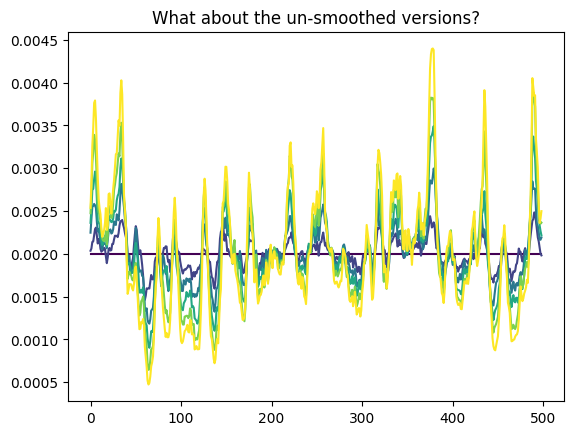

In [212]:
colors = plt.cm.viridis(np.linspace(0,1,6))

dist = AngleDistribution( np.ones(500), [0., np.pi])
plt.plot(dist.bin_probs, c=colors[0])

i = 1
for row in concentrated_data[(concentrated_data.measurement == 'FI') &
                             (concentrated_data.iteration == 0)
                            ]['data']:

    new_values = dist.values / row**0.5
    dist = AngleDistribution(new_values, [0., np.pi])
    plt.plot(dist.bin_probs, c=colors[i])
    i += 1

plt.title('What about the un-smoothed versions?')

I mean, yes. This is essentially the same as the behavior that we saw above.

So the smoothing is not the cause of the similarity.

### Is it a result of the shared initialization?

In this way, initialization looks to be a sort of constraint on the network that is being pulled out of the noise?